### BRDF from Brightness Observation
This code infers the BRDFs of the Starlink v1.5's primary surfaces
by reducing the error between observation and model prediction. The
BRDFs are assumed to be Phong BRDFs with 3 free parameters.

In [1]:
# Imports

import scipy.optimize
import lumos.brdf.library
import pandas as pd
import lumos.calculator
import lumos.conversions
import numpy as np
import astropy.coordinates
import scipy.stats
import matplotlib.pyplot as plt
from lumos.geometry import Surface
from lumos.brdf.library import BINOMIAL, PHONG
from matplotlib.ticker import StrMethodFormatter

In [2]:
# Read database

data = pd.read_csv(r"C:\Users\27549\Desktop\course_file\presonal_project\Satellite_Optical_Brightness_MSc_Project\ReFitting\Data_for_Fitting.csv", comment = "#")

sat_alts= data['sat_alt'].to_numpy()
sat_azs= data['sat_az'].to_numpy()
sat_hs= 1000 *data['sat_height'].to_numpy()
sun_alts= data['sun_alt'].to_numpy()
sun_azs= data['sun_az'].to_numpy()
area_SAs= data['A_eff_SA'].to_numpy()
A_eff_chassiss=data['A_eff_chassis'].to_numpy()
measured_magnitudes= data['measured_mag'].to_numpy()
SolarPhaseAngle= data['phase_angle'].to_numpy()



mount_lemmon = astropy.coordinates.EarthLocation(lat = 32.4434, lon = -110.7881)

In [ ]:

# Optimization function with A_eff_SA
def optimization(params):
    p1, p2, p3, p4, p5, p6 = params  # BRDF parameters

    calculated_intensities = np.zeros_like(measured_magnitudes)

    for i, (sat_alt, sat_az, sun_alt, sun_az, area_SA,A_eff_chassis,sat_h) in enumerate(
        zip(sat_alts, sat_azs, sun_alts, sun_azs, area_SAs,A_eff_chassiss,sat_hs)):

        # Define surfaces with dynamic solar array area
        surfaces = [
            Surface(A_eff_chassis/3.64, np.array([0, 0, -1]), lumos.brdf.library.PHONG(p1, p2, p3)),  # Chassis
            Surface(area_SA/22.68, np.array([0, 1, 0]), lumos.brdf.library.PHONG(p4, p5, p6))  # Solar array
        ]

        calculated_intensities[i] = lumos.calculator.get_intensity_observer_frame(
            surfaces,
            sat_h,
            sat_alt,
            sat_az,
            sun_alt,
            sun_az,
            include_sun=True,
            include_earthshine=False
        )

    calculated_magnitudes = lumos.conversions.intensity_to_ab_mag(calculated_intensities)
    error = calculated_magnitudes - measured_magnitudes
    rms = np.sqrt(np.mean(error**2))
    return rms

# Run optimization
sol = scipy.optimize.minimize(
    optimization,
    x0=(0.5, 0.5, 10, 0.1, 0.1, 8),
    bounds=((0.1, 5), (0.1, 5), (0, 100),
    (0, 1), (0, 1), (0, 100)),
    method='L-BFGS-B'  # Recommended for bounded optimization
)

# Print results
Kd1, Ks1, n1, Kd2, Ks2, n2 = sol.x
print(f"\nOptimization Results:")
print(f"RMS error = {sol.fun:.3f} magnitudes")

In [4]:
print("Chassis Inferred BRDF Parameters")
print("------------------------------------")
print(f" {Kd1:0.2f},{Ks1:0.2f},{n1:0.2f}")


print("Solar Array Inferred BRDF Parameters")
print("------------------------------------")
print(f" {Kd2:0.2f},{Ks2:0.2f},{n2:0.2f}")

Chassis Inferred BRDF Parameters
------------------------------------
 0.44,0.33,12.25
Solar Array Inferred BRDF Parameters
------------------------------------
 0.04,0.35,0.28


In [5]:
# Initialize array for inferred BRDF results
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)

# Calculate intensities using inferred BRDFs with dynamic areas
for i, (sat_alt, sat_az, sun_alt, sun_az, area_SA, A_eff_chassis) in enumerate(
    zip(sat_alts, sat_azs, sun_alts, sun_azs, area_SAs, A_eff_chassiss)):

    #
    surfaces = [
        Surface(A_eff_chassis/3.64, np.array([0, 0, -1]), PHONG(Kd1, Ks1, n1)),  # 底盘
        Surface(area_SA/22.68, np.array([0, 1, 0]), PHONG(Kd2, Ks2, n2))  # 太阳能板
    ]

    intensities_inferred_brdfs[i] = lumos.calculator.get_intensity_observer_frame(
        surfaces,
        550000,
        sat_alt,
        sat_az,
        sun_alt,
        sun_az,
        include_sun=True,
        include_earthshine=False
    )

# Convert intensities to magnitudes
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

# Calculate statistics
error = magnitudes_inferred_brdfs - measured_magnitudes
rms = np.sqrt(np.mean(error**2))
corr, _ = scipy.stats.pearsonr(magnitudes_inferred_brdfs, measured_magnitudes)
chi_square_statistic = lambda modeled, measured: np.sum((modeled - measured)**2 / measured) / len(measured)
chi_sq = chi_square_statistic(magnitudes_inferred_brdfs, measured_magnitudes)

print(f"\nOptimized BRDF Model Performance:")
print(f"RMS error = {rms:.3f} magnitudes")
print(f"Pearson R = {corr:.4f}")
print(f"Chi-squared = {chi_sq:.4f}")


Optimized BRDF Model Performance:
RMS error = 0.688 magnitudes
Pearson R = 0.6926
Chi-squared = 0.0809


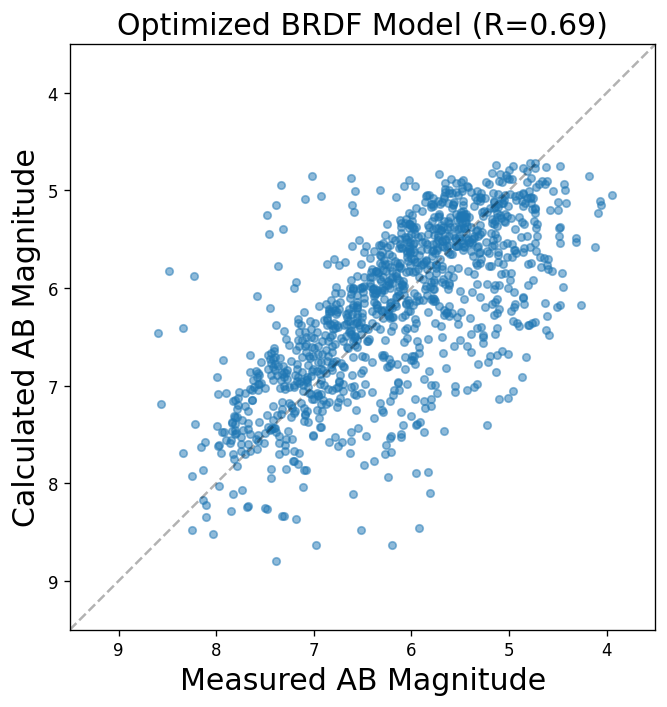

In [6]:
# Plot measured vs calculated magnitudes
plt.figure(figsize=(8, 6), dpi=120)
plt.xlim((3.5, 9.5))
plt.ylim((3.5,9.5))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")
plt.xlabel("Measured AB Magnitude", fontsize=18)
plt.ylabel("Calculated AB Magnitude", fontsize=18)
plt.plot([9.5, 3.5], [9.5, 3.5], '--k', alpha=0.3, label='1:1 line')
plt.scatter(measured_magnitudes, magnitudes_inferred_brdfs,
           color='#1f77b4', alpha=0.5, s=20, label='Observations')
plt.title(f"Optimized BRDF Model (R={corr:.2f})", fontsize=18)
plt.xticks([ 9, 8, 7, 6, 5, 4])
plt.yticks([ 9, 8, 7, 6, 5, 4])
#plt.legend()
plt.tight_layout()
plt.show()

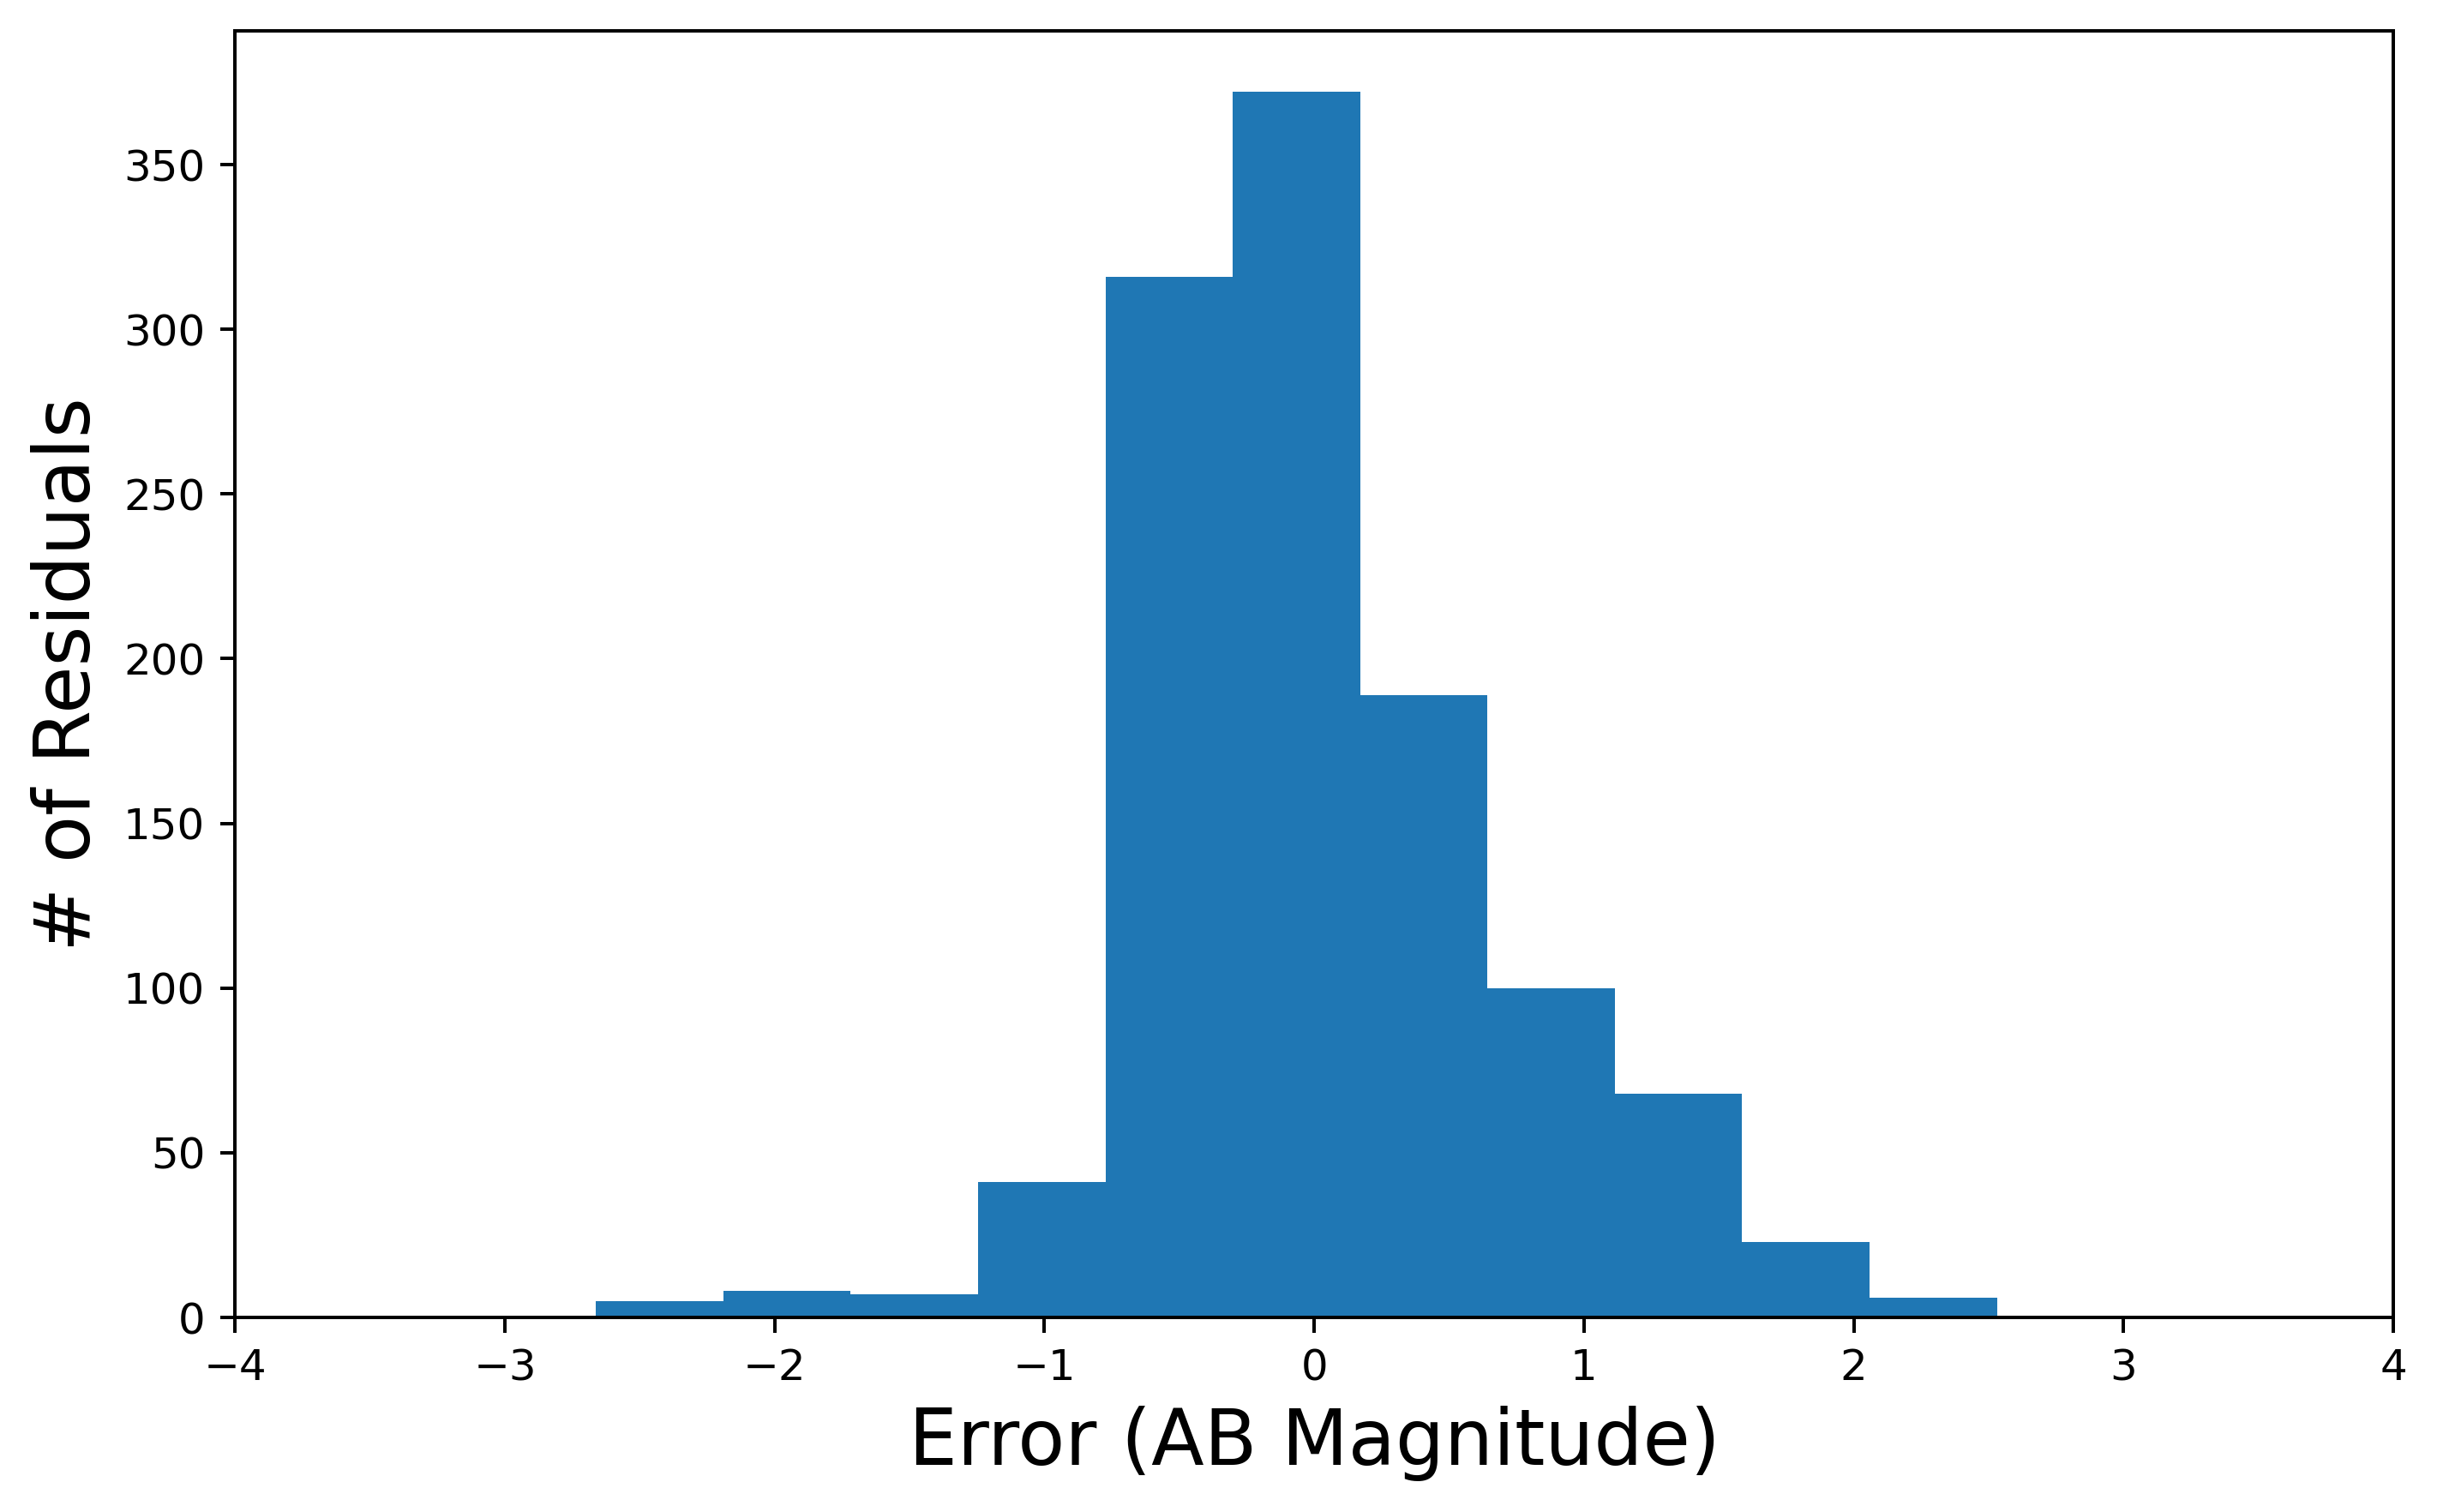

In [7]:
# Plot error distribution
plt.figure(figsize=(8, 5), dpi=360)
plt.xlim((-4, 4))
plt.xlabel("Error (AB Magnitude)", fontsize=18)
plt.ylabel("# of Residuals", fontsize=18)
plt.hist(error, bins=11, color='#1f77b4')
#plt.title(f"Residual Distribution", fontsize=14)
#plt.title(f"Residual Distribution (μ={np.mean(error):.2f}, σ={np.std(error):.2f})", fontsize=14)
#plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

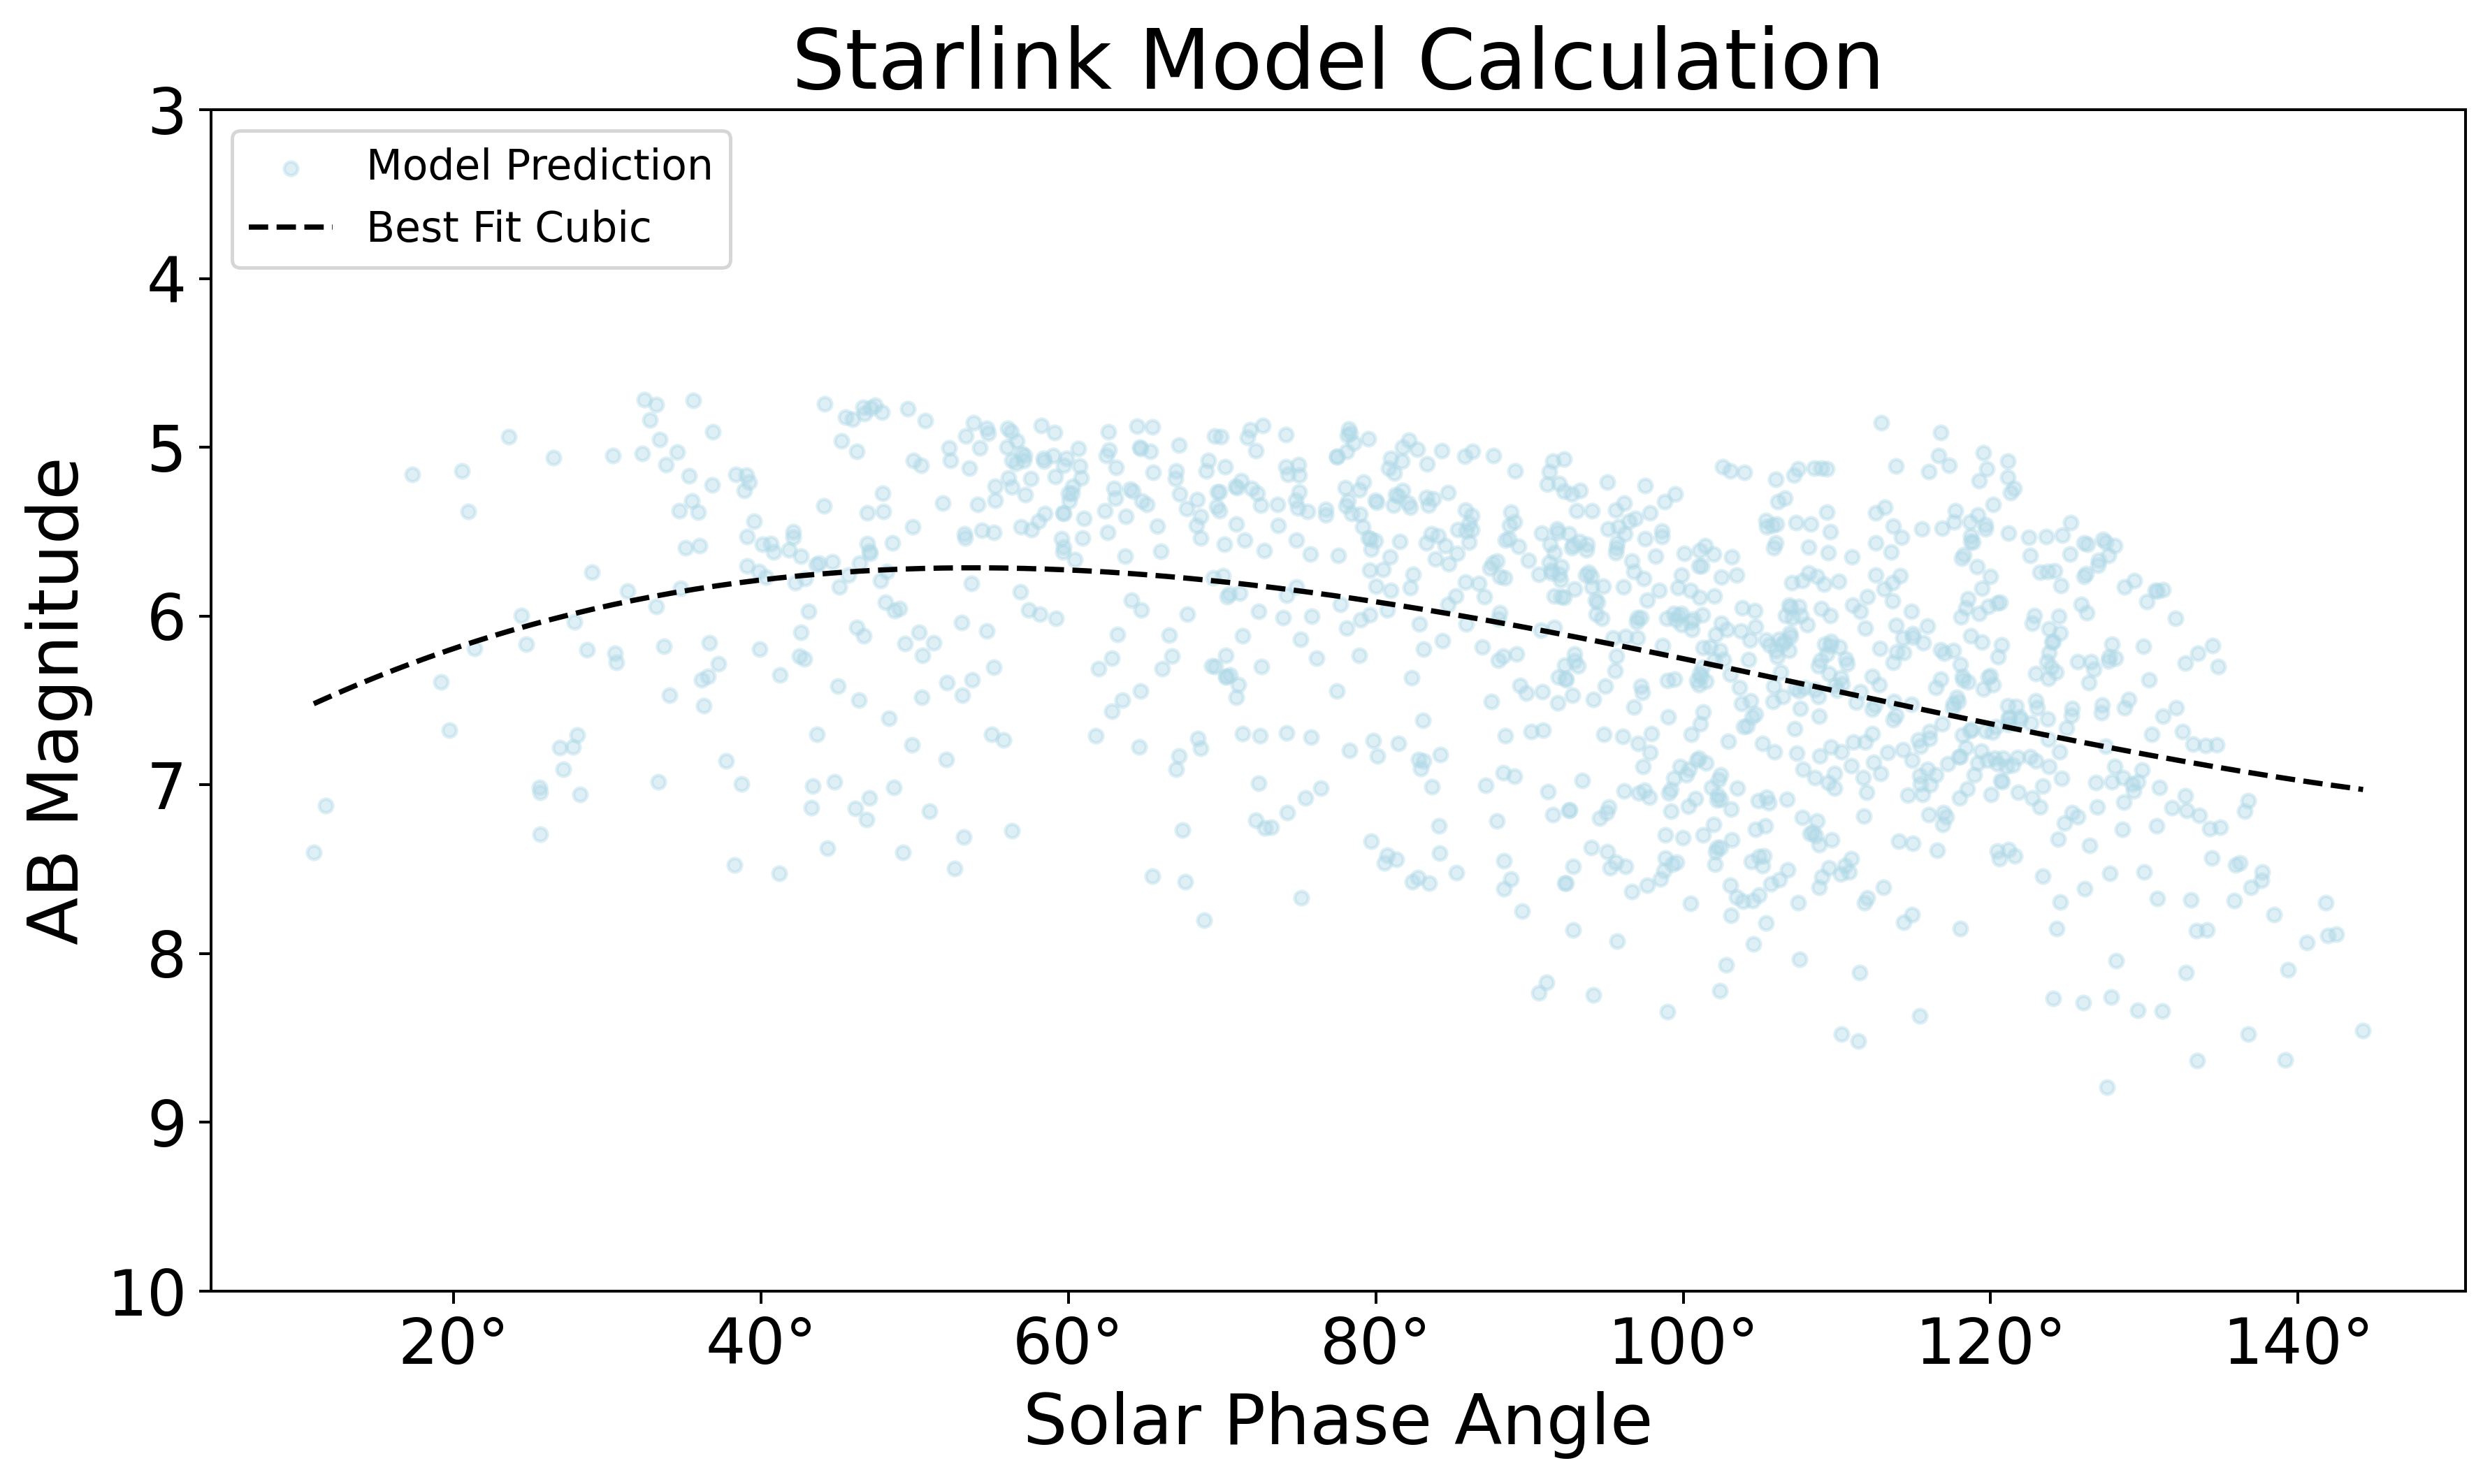

In [11]:
# === 1) Extract data already computed ===
phase = np.asarray(SolarPhaseAngle)                 # Solar phase angle (in degrees)
abmag = np.asarray(magnitudes_inferred_brdfs)       # Calculated AB magnitudes

# === 2) Clean data (remove NaN/Inf) ===
mask = np.isfinite(phase) & np.isfinite(abmag)
phase_clean = phase[mask]
abmag_clean = abmag[mask]

# Optional: sort by phase angle for smoother fitted curve
order = np.argsort(phase_clean)
phase_clean = phase_clean[order]
abmag_clean = abmag_clean[order]

# === 3) Plot ===
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=360)

ax.set_ylim(3, 10)
ax.invert_yaxis()  # Magnitude scale decreases with brightness, so invert y-axis
ax.set_xlabel("Solar Phase Angle", fontsize=20)
ax.set_ylabel("AB Magnitude", fontsize=20)
ax.set_title("Starlink Model Calculation", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Format x-axis as degrees

# Model prediction scatter (calculated AB magnitudes vs phase angle)
ax.scatter(phase_clean, abmag_clean, alpha=0.4, s=15, label="Model Prediction", color='lightblue')

# === 4) Fit a cubic polynomial if we have at least 4 data points ===
if len(phase_clean) >= 4:
    # Fit: abmag = a1*x^3 + a2*x^2 + a3*x + a4
    a1, a2, a3, a4 = np.polyfit(phase_clean, abmag_clean, deg=3)
    x = np.linspace(phase_clean.min(), phase_clean.max(), 200)
    y = a1*x**3 + a2*x**2 + a3*x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")

ax.legend(loc=2, prop={'size': 12})
plt.tight_layout()
plt.show()